In [93]:
import pickle
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import solve, norm
from scipy.cluster.hierarchy import fcluster
import yfinance as yf



In [94]:
# get first 9 csv files and store them in a dictionary 

adjusted_data = pd.read_csv('rds_data/adjusted.csv')
BBr_data = pd.read_csv('rds_data/BBr.csv')
PNlog_data = pd.read_csv('rds_data/PNlog.csv')

In [95]:
begin_date = "2015-01-01"  # "2015-01-01" # not including
end_date = "2016-12-31" #"2019-12-20" #"2017-12-31" # including

In [96]:
# Download historical data for a specific stock
ticker = 'SPX'
SP500_index = yf.download(ticker, start=begin_date, end=end_date)

print(SP500.head())


[*********************100%%**********************]  1 of 1 completed

               Open     High      Low    Close  Adj Close  Volume
Date                                                             
2015-01-02  0.01300  0.01300  0.01300  0.01300    0.01300   24689
2015-01-05  0.01372  0.01444  0.01372  0.01444    0.01444  232307
2015-01-06  0.01444  0.01444  0.01444  0.01444    0.01444       0
2015-01-07  0.01444  0.01444  0.01444  0.01444    0.01444       0
2015-01-08  0.01444  0.01444  0.01444  0.01444    0.01444  692308


set date column as index for each dataframe

In [97]:
# convert the 'Date' column to datetime
adjusted_data['Date'] = pd.to_datetime(adjusted_data['Date'])   
BBr_data['Date'] = pd.to_datetime(BBr_data['Date'])
PNlog_data['Date'] = pd.to_datetime(PNlog_data['Date'])

# set index to Date
adjusted_data.set_index('Date', inplace=True)
BBr_data.set_index('Date', inplace=True)
PNlog_data.set_index('Date', inplace=True)

# take only first 9 columns 
adjusted_data = adjusted_data.iloc[:, :9]
BBr_data = BBr_data.iloc[:, :9]
PNlog_data = PNlog_data.iloc[:, :9]

Here we define functions to calculate returns, correlation matrices, and prep the data.

In [98]:
def log_return(df):
    '''
    Calculate the log return of a dataframe
    '''
    return np.log(df).diff().drop(index=df.index[0], axis=0, inplace=False)

def na_fill(df):
    # fills with mean of previous and next value
    # Simulates `na.fill(as.xts(rowAvgs(df),order.by=index(df)),"extend")`
    return df.interpolate(method="linear").fillna(method="bfill")

def create_index(df):
    # the linear method already does ffill for the tail values
    # fills the rest with the mean of the column
    return na_fill(df.mean(axis=1, skipna=False))

def cov2cor(df):
    # convert covariance matrix to correlation matrix by dividing by the outer product of the standard deviations
    # this is equivalent to multiplying by the inverse of the diagonal matrix of standard deviations
    ind = df.index
    col = df.columns
    sigma = np.sqrt(np.diag(df))
    return df.div(pd.DataFrame(np.outer(sigma, sigma), index=ind, columns=col))

def clusterplot(cov, ncluster=6):
    # plot the correlation matrix with a dendrogram correlation matrix of the clusters
    sns.set(style='white')
    sns_plot = sns.clustermap(cov2cor(cov), cmap='vlag_r', robust=True, method="complete", vmin=-1, vmax=1)
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), color='red')
    plt.setp(sns_plot.ax_heatmap.xaxis.get_majorticklabels(), color='red')
    plt.title("Correlation")

    Z = sns_plot.dendrogram_row.linkage
    clusters = list(fcluster(Z, ncluster, criterion='maxclust'))
    assign_cluster = dict((k, clusters[k]) for k in range(len(cov.columns)))
    assigned_idx = [assign_cluster[idx] for idx in sns_plot.dendrogram_row.reordered_ind]
    i = 0
    while i < len(assigned_idx):
        cluster = assigned_idx[i]
        counter = 0
        while i < len(assigned_idx) and assigned_idx[i] == cluster:
            counter += 1
            i += 1
        sns_plot.ax_heatmap.add_patch(plt.Rectangle(
            xy=(i-counter, i-counter),
            width=counter,
            height=counter,
            fill=None, color='black', lw=1.5
        ))
    plt.show()

Here we begin to prep the data

First we get the French Factors data which is the market, size, value, and momentum factors. 

In [99]:

# Fama-French factors
# url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"

fama_lib = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", skiprows=4, skipfooter=1, index_col=0, engine='python')
fama_lib.index = pd.to_datetime(fama_lib.index, format="%Y%m%d")
fama_lib = fama_lib.iloc[:, 0:3] # We only use the first 3 columns

Then we read in the SP500 benchmark as a reference for the market factor.

In [100]:

# fill na values with interpolation
SP500_index = SP500.interpolate(method='linear')

# apply log return to the SP500 index
SP500_index['log_return'] = SP500_index['Adj Close'].pct_change().apply(lambda x: np.log(1+x))

SP500_index.head()

,Open,High,Low,Close,Adj Close,Volume,log_return
Date,,,,,,,
2015-01-02,0.01300,0.01300,0.01300,0.01300,0.01300,24689,NaN
2015-01-05,0.01372,0.01444,0.01372,0.01444,0.01444,232307,0.105053
2015-01-06,0.01444,0.01444,0.01444,0.01444,0.01444,0,0.000000
2015-01-07,0.01444,0.01444,0.01444,0.01444,0.01444,0,0.000000
2015-01-08,0.01444,0.01444,0.01444,0.01444,0.01444,692308,0.000000


In [101]:


stockPrices = adjusted_data.truncate(
    before=begin_date,
    after=end_date
)
X = log_return(stockPrices)
T, N = X.shape  # nrow and ncol

F_FamaFrench = fama_lib.loc[X.index]/100   # Fama-French factors
BBrMkt = create_index(BBr_data)/100  # BBr Market index
PNlogMkt = create_index(PNlog_data)  # PNlog Market index
SentIndx = PNlogMkt.loc[X.index]           # Sentiment index


# FamaFrench + Sent index
FFS = na_fill(pd.merge(
    fama_lib.loc[X.index], SentIndx.rename("SentIndx"),
    left_index=True, right_index=True
))

# Sp500 + Sent index
SPS = na_fill(pd.merge(
    SP500_index.loc[X.index], SentIndx.rename("SentIndx"),
    left_index=True, right_index=True
))

# split data into training and test data
T_trn = round(0.5*T)
X_trn = X.iloc[0:T_trn, ]
X_tst = X.iloc[T_trn:T, ]
F_FamaFrench_trn = F_FamaFrench.iloc[0:T_trn, ]
F_FamaFrench_tst = F_FamaFrench.iloc[T_trn:T, ]
f_SP500_trn = SP500_index.iloc[0:T_trn, ]
f_SP500_tst = SP500_index.iloc[T_trn:T, ]
SentIndx_trn = SentIndx.iloc[0:T_trn,]
SentIndx_tst = SentIndx.iloc[T_trn:T,]
FFS_trn = FFS.iloc[0:T_trn,]
FFS_tst = FFS.iloc[T_trn:T,]
SPS_trn = SPS.iloc[0:T_trn,]
SPS_tst = SPS.iloc[T_trn:T,]

/var/folders/d4/rcb0hfcs0bzgr7z0mw72lc_w0000gn/T/ipykernel_5869/4183366688.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(method="linear").fillna(method="bfill")
/var/folders/d4/rcb0hfcs0bzgr7z0mw72lc_w0000gn/T/ipykernel_5869/4183366688.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(method="linear").fillna(method="bfill")
/var/folders/d4/rcb0hfcs0bzgr7z0mw72lc_w0000gn/T/ipykernel_5869/4183366688.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(method="linear").fillna(method="bfill")
/var/folders/d4/rcb0hfcs0bzgr7z0mw72lc_w0000gn/T/ipykernel_5869/4183366688.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in 

Model 1

In [102]:
# Estimate the different factor models with the training data:
Sigma_SCM = X_trn.cov()  # Sample covariance matrix

In [103]:
F.head()

,ones,log_return,SentIndx
Date,,,
2015-01-05,1,0.105053,0.000942
2015-01-06,1,0.000000,-0.001774
2015-01-07,1,0.000000,-0.000031
2015-01-08,1,0.000000,0.007227
2015-01-09,1,-0.162030,-0.009979


##  Fama-French 3-factor model

In [104]:

F = F_FamaFrench_trn.copy()
F.insert(0, 'ones', 1)
Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta1", "beta2", "beta3"])
alpha = Gamma["alpha"]
B = Gamma[["beta1", "beta2", "beta3"]]
E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
PsiFF = (E.T @ E) / (T_trn - 4)
Sigma_FamaFrench = B.to_numpy() @ F_FamaFrench_trn.cov() @ B.to_numpy().T + np.diag(np.diag(PsiFF))

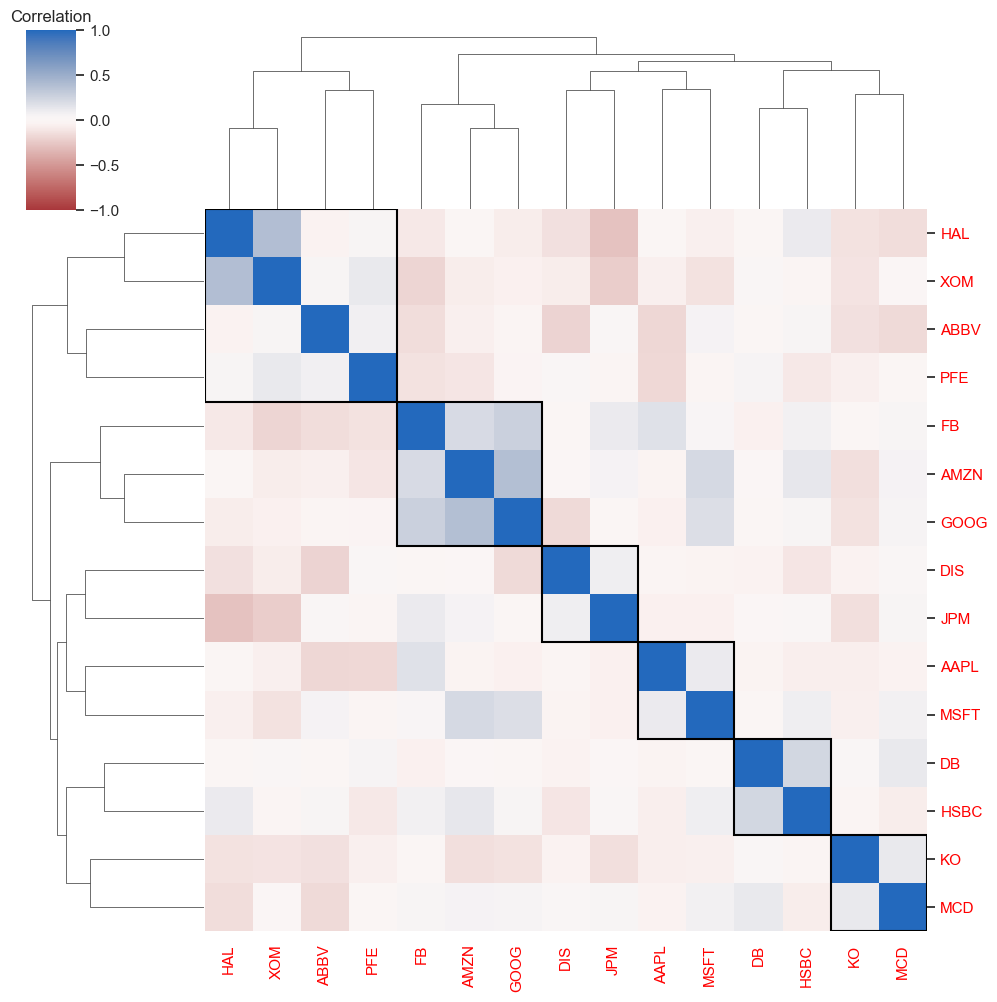

In [105]:
Psi = PsiFFS

numclust = 6 #5 #3
clusterplot(Psi, numclust)

The cluster of FB AMZN and GOOG seems to have the highest correlation. This follows industry trends such as the Jim Cramer termed FAANG index. Duetsche Bank and HSBC are also highly correlated and makes sense as they are both banks. Haliburton and Exxon Mobile are also highly correlated and it makes sense as they are both oil companies.

In [109]:
Sigma_true = X_tst.cov()

# ntype = 2    # Square Error
ntype = "fro"  # Frobenious

stockPricesNew = stockPrices - Sigma_true

stockPricesNew

,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
2015-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
DIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GOOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
log_return(stockPrices) 

,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
Date,,,,,,,,,
2015-01-05,-0.028576,-0.018999,-0.020731,-0.055673,-0.014721,-0.016191,-0.021066,-0.019950,-0.023212
2015-01-06,0.000094,-0.004962,-0.023098,-0.016090,-0.005318,-0.013565,-0.023450,-0.009865,-0.014676
2015-01-07,0.013925,0.039621,0.010544,0.010523,0.010178,0.000000,-0.001715,0.026517,0.007693
2015-01-08,0.037703,0.010404,0.006813,0.002091,0.010288,0.026309,0.003148,0.021365,0.003279
2015-01-09,0.001071,-0.027736,-0.011818,-0.016854,0.004892,-0.005644,-0.013035,-0.010249,-0.005252
...,...,...,...,...,...,...,...,...,...
2016-12-23,0.001976,0.010968,-0.007531,0.004843,-0.002564,-0.001108,-0.001708,-0.004185,-0.011719
2016-12-27,0.006331,0.002563,0.014113,-0.014054,0.000190,0.006290,0.002074,0.001275,0.000000
2016-12-28,-0.004273,-0.003687,0.000946,-0.024801,-0.008307,-0.009279,-0.008246,-0.011171,-0.002511


In [115]:
Sigma_true

,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
AAPL,0.000218,0.000062,0.000099,0.000083,0.000063,0.000094,0.000088,0.000077,0.000086
ABBV,0.000062,0.000293,0.000075,0.000113,0.000049,0.000060,0.000056,0.000086,0.000053
AMZN,0.000099,0.000075,0.000336,0.000107,0.000055,0.000187,0.000137,0.000095,0.000080
DB,0.000083,0.000113,0.000107,0.001097,0.000144,0.000098,0.000094,0.000249,0.000397
DIS,0.000063,0.000049,0.000055,0.000144,0.000116,0.000043,0.000049,0.000088,0.000083
FB,0.000094,0.000060,0.000187,0.000098,0.000043,0.000306,0.000141,0.000101,0.000086
GOOG,0.000088,0.000056,0.000137,0.000094,0.000049,0.000141,0.000158,0.000064,0.000074
HAL,0.000077,0.000086,0.000095,0.000249,0.000088,0.000101,0.000064,0.000444,0.000169
HSBC,0.000086,0.000053,0.000080,0.000397,0.000083,0.000086,0.000074,0.000169,0.000279


In [ ]:


print(
f"""
ntype: {ntype}
begin_date, end_date: {begin_date}, {end_date}
{error}
""")

order = ["SCM", "SP500", "SentInd", "FamaFrench", "FFwSent", "SPwSent"]
alt.Chart(error.melt(value_name='error')).mark_bar().encode(
    x = alt.X('variable', title='', axis=alt.Axis(labelAngle=0), sort=order),
    y = 'error',
    color = alt.value("mediumaquamarine")
).properties(
    title="Error in estimation of covariance matrix",
    height=300,
    width=400
)

In [ ]:
ref = norm(Sigma_SCM - Sigma_true, ord=ntype)**2
PRIAL = 100*(ref - error**2)/ref
print(f"""
ntype: {ntype}
begin_date, end_date: {begin_date}, {end_date}
{PRIAL}
""")

## results with ntype="F"
##period: "2015-01-01" -- "2017-12-31"
# SCM         SP500    SentInd    FamaFrench    FFwSent  SPwSent
# 0.000000  -4.429915  48.934849  -1.101584  -1.067530  -4.662129

##period: "2017-01-01" -- 2019-12-20
#SCM        SP500    SentInd    FamaFrench    FFwSent   SPwSent
#0.00000 -253.53723 -253.00818  -10.32885  -10.21780  -16.73770

##period: "2018-01-01" -- "2019-12-20"
# SCM         SP500    SentInd    FamaFrench    FFwSent  SPwSent
# 0.000000  -53.127359 -50.766802  -3.380414  -3.351638  -7.613154

##period: "2015-01-01" -- 2019-12-20
#SCM      SP500    SentInd FamaFrench    FFwSent   SPwSent
#0.00000 -30.79891 -433.02268  -17.17345  -17.20375  -30.93734

order = ["SCM", "SP500", "SentInd", "FamaFrench", "FFwSent", "SPwSent"]
alt.Chart(PRIAL.melt(value_name='error')).mark_bar().encode(
    x = alt.X('variable', title='', axis=alt.Axis(labelAngle=0), sort=order),
    y = 'error',
    color = alt.value("tan")
).properties(
    title="PRIAL for estimation of covariance matrix",
    height=300,
    width=400
)

## 1.d. Fama-French + Sentiment 4-factor model

In [81]:
F = FFS_trn.copy()
F.insert(0, 'ones', 1)
Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta1", "beta2", "beta3", "beta4"])
alpha = Gamma["alpha"]
B = Gamma[["beta1", "beta2", "beta3", "beta4"]]
E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
PsiFFS = (E.T @ E) / (T_trn - 4)
Sigma_FFS = B.to_numpy() @ FFS_trn.cov() @ B.to_numpy().T + np.diag(np.diag(PsiFFS))

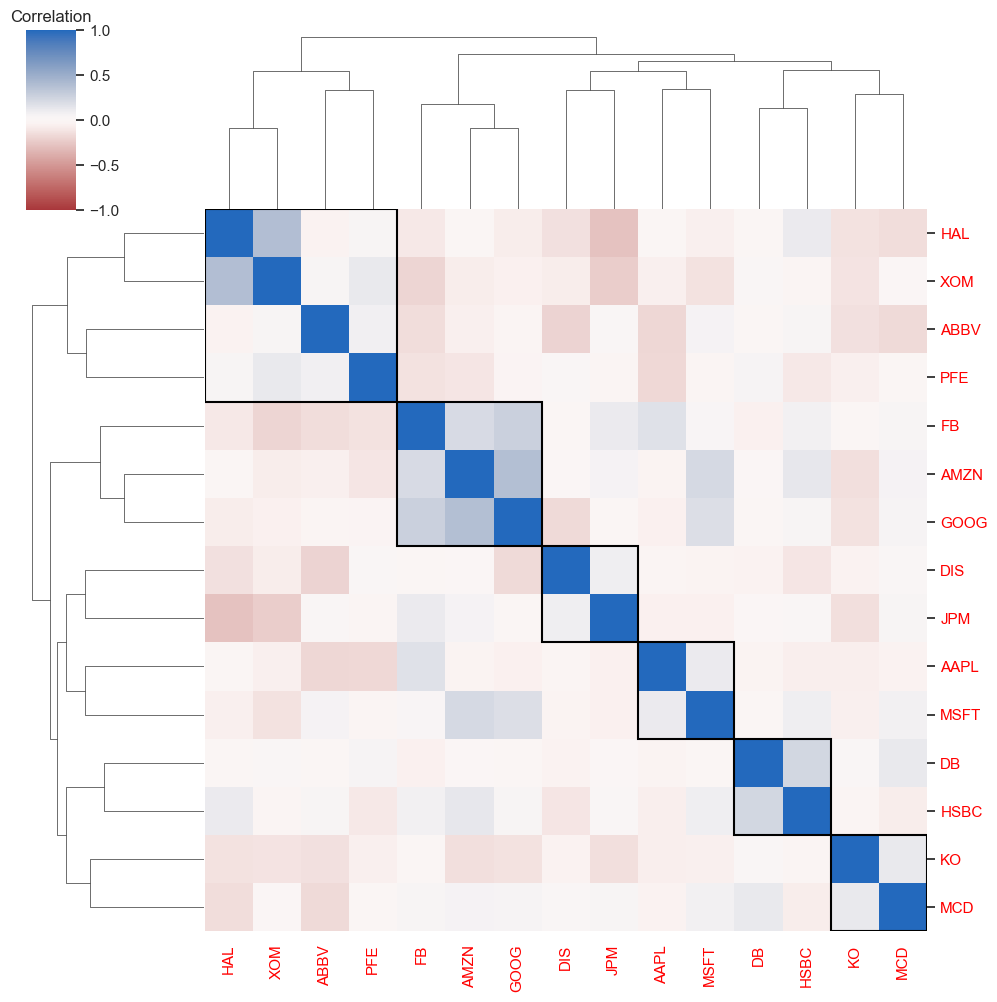